In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from skimage.io import imread, imshow, show, imshow_collection
from skimage.transform import resize, rescale, rotate

warnings.filterwarnings('ignore')

# Load Data

In [2]:
data_train_1 = pickle.load(open("data/data_train_flatten_batch_1.pkl", "rb"))
data_train_2 = pickle.load(open("data/data_train_flatten_batch_2.pkl", "rb"))
labels_train_1 = pickle.load(open("data/labels_train_batch_1.pkl", "rb"))
labels_train_2 = pickle.load(open("data/labels_train_batch_2.pkl", "rb"))

In [3]:
data_train = np.concatenate((data_train_1, data_train_2))
labels_train = np.concatenate((labels_train_1, labels_train_2))

In [4]:
data_test = pickle.load(open("data/data_test_flatten.pkl", "rb"))
labels_test = pickle.load(open("data/labels_test.pkl", "rb"))

In [5]:
# Shuffle train set
data_train, labels_train = shuffle(data_train, labels_train, random_state=25)

# Scale Data

In [6]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(data_train)
X_test_std = scaler.transform(data_test)

# PCA
We will use a 95% PCA

In [7]:
print("original number of features:", X_train_std.shape[1])
pca = PCA(0.95)
pca.fit(X_train_std)
print("Number of pricipal components:", pca.n_components_)

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

original number of features: 3072
Number of pricipal components: 221


# Train Model

In [8]:
# Create custom scorer for tuning
def f1_global(y_true, y_pred):
    precision_macro = precision_score(y_true, y_pred, average="macro")
    recall_macro = recall_score(y_true, y_pred, average="macro")
    return (2 * precision_macro * recall_macro) / (precision_macro + recall_macro)

f1_global_scorer = make_scorer(f1_global, greater_is_better=True)


m = LogisticRegression()

parameters = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "multi_class": ["multinomial", "ovr"]
    },
    {
        "solver": ["saga"],
        "penalty": [None, "l1", "elasticnet"],
        "multi_class": ["multinomial", "ovr"]
    }
]

grid_search = GridSearchCV(m, parameters, verbose=3, scoring=f1_global_scorer)
grid_search.fit(X_train_pca, labels_train)
model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.404 total time=   3.4s
[CV 2/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.405 total time=   3.4s
[CV 3/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.410 total time=   3.4s
[CV 4/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.400 total time=   3.6s
[CV 5/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.405 total time=   3.5s
[CV 1/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.403 total time=   8.6s
[CV 2/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.400 total time=   8.5s
[CV 3/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.404 total time=   8.2s
[CV 4/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.397 total time=   8.5s
[CV 5/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.401 total time=   8.1s
[CV 1/5] END multi_c

In [9]:
print("Model optimal parameters".upper())
print("solver:", model.get_params()["solver"])
print("penalty:", model.get_params()["penalty"])
print("multi_class:", model.get_params()["multi_class"])

MODEL OPTIMAL PARAMETERS
solver: saga
penalty: l1
multi_class: multinomial


# Test Model

In [10]:
predictions = model.predict(X_test_pca)

accuracy = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions, average="macro")
recall = recall_score(labels_test, predictions, average="macro")
f1_macro = f1_score(labels_test, predictions, average="macro")
f1_glob = (2 * precision * recall) / (precision + recall)

print("Accuracy score: {:.4f}%\nPrecision macro: {:.4f}%\nRecall macro: {:.4f}%".format(accuracy*100,precision*100,recall*100))
print("\nF1 macro: {:.4f}%\nF1 global: {:.4f}%".format(f1_macro*100, f1_glob*100))

Accuracy score: 40.6000%
Precision macro: 40.0927%
Recall macro: 40.6000%
F1 macro: 40.2075%


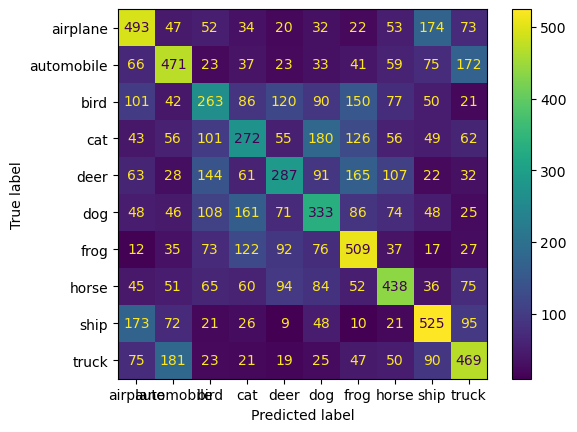

In [11]:
cm = confusion_matrix(labels_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# Save Model

In [12]:
model_file_name = "lr_pca.pkl"
pickle.dump(model, open(model_file_name, "wb"))

# Black And White

## Load data

In [13]:
train_batches = []
labels_batches = []

for i in [1, 2, 3, 4, 5]:
    data_filepath = "data/data_train_bw_flatten_batch_" + str(i) + ".pkl"
    labels_filepath = "data/labels_train_bw_batch_" + str(i) + ".pkl"
    train_batches.append(pickle.load(open(data_filepath, "rb")))
    labels_batches.append(pickle.load(open(labels_filepath, "rb")))
    
data_train_bw = np.concatenate(train_batches)
labels_train_bw = np.concatenate(labels_batches)

data_test_bw = pickle.load(open("data/data_test_bw_flatten.pkl", "rb"))
labels_test_bw = pickle.load(open("data/labels_test_bw.pkl", "rb"))

# Shuffle train set
data_train_bw, labels_train_bw = shuffle(data_train_bw, labels_train_bw, random_state=25)

## Scale data

In [14]:
scaler = StandardScaler()

X_train_std_bw = scaler.fit_transform(data_train_bw)
X_test_std_bw = scaler.transform(data_test_bw)

## PCA
We will use a 95% PCA

In [15]:
del pca
print("original number of features:", X_train_std_bw.shape[1])
pca = PCA(0.95)
pca.fit(X_train_std_bw)
print("Number of pricipal components:", pca.n_components_)

X_train_bw_pca = pca.transform(X_train_std_bw)
X_test_bw_pca = pca.transform(X_test_std_bw)

original number of features: 1024
Number of pricipal components: 163


## Train model

In [16]:
m = LogisticRegression()

parameters = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "multi_class": ["multinomial", "ovr"]
    },
    {
        "solver": ["saga"],
        "penalty": [None, "l1", "elasticnet"],
        "multi_class": ["multinomial", "ovr"]
    }
]

grid_search = GridSearchCV(m, parameters, verbose=3, scoring=f1_global_scorer)
grid_search.fit(X_train_bw_pca, labels_train_bw)
model_bw = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.300 total time=   3.3s
[CV 2/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.298 total time=   3.1s
[CV 3/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.289 total time=   3.3s
[CV 4/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.296 total time=   3.3s
[CV 5/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.296 total time=   3.2s
[CV 1/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.301 total time=   5.6s
[CV 2/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.295 total time=   5.5s
[CV 3/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.287 total time=   5.9s
[CV 4/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.294 total time=   5.7s
[CV 5/5] END multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.295 total time=   5.6s
[CV 1/5] END multi_c

In [17]:
print("Model optimal parameters".upper())
print("solver:", model_bw.get_params()["solver"])
print("penalty:", model_bw.get_params()["penalty"])
print("multi_class:", model_bw.get_params()["multi_class"])

MODEL OPTIMAL PARAMETERS
solver: lbfgs
penalty: l2
multi_class: multinomial


## Test model

In [18]:
predictions_bw = model_bw.predict(X_test_bw_pca)

accuracy_bw = accuracy_score(labels_test_bw, predictions_bw)
precision_bw = precision_score(labels_test_bw, predictions_bw, average="macro")
recall_bw = recall_score(labels_test_bw, predictions_bw, average="macro")
f1_macro_bw = f1_score(labels_test_bw, predictions_bw, average="macro")
f1_glob_bw = (2 * precision_bw * recall_bw) / (precision_bw + recall_bw)

print("Accuracy score: {:.4f}%\nPrecision macro: {:.4f}%\nRecall macro: {:.4f}%".format(accuracy_bw*100,precision_bw*100,recall_bw*100))
print("F1 macro: {:.4f}%\nF1 global: {:.4f}".format(f1_macro_bw*100, f1_glob_bw*100))

Accuracy score: 30.5300%
Precision macro: 29.9176%
Recall macro: 30.5300%
F1 macro: 30.0276%


[]

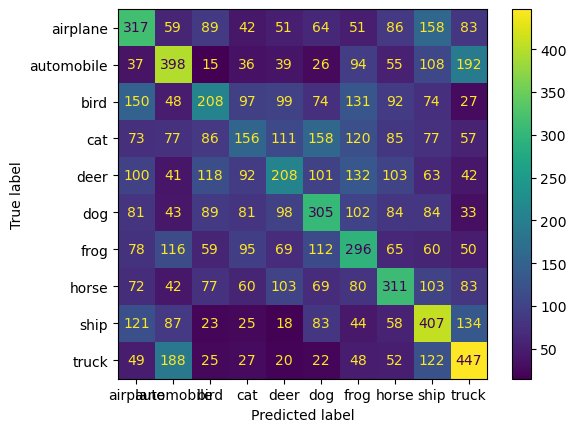

In [19]:
cm = confusion_matrix(labels_test_bw, predictions_bw, labels=model_bw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_bw.classes_)
disp.plot()
plt.plot()

## Save model

In [20]:
model_file_name_bw = "lr_bw_pca.pkl"
pickle.dump(model_bw, open(model_file_name_bw, "wb"))